# PhaseSpace + DecayLanguage - lightning talk
Primary author: Simon Thor

Co-authors: Jonas Eschle, Eduardo Rodrigues, Albert Puig

This tutorial/lightning talk is based on the one in the [PhaseSpace documentation](https://github.com/zfit/phasespace/blob/master/docs/GenMultiDecay_Tutorial.ipynb).

PhaseSpace and more specifically the new feature I have developed will:
- Make it easy to simulate phase space generation
- Load decays from DecayLanguage to PhaseSpace
- easily specify resonances at various levels of customizability 

## Installation
In order to use this functionality, you need to install the extra dependencies to PhaseSpace by running
`pip install "phasespace[fromdecay]"`.

In [3]:
# Import libraries
from pprint import pprint
from copy import deepcopy
import zfit
from particle import Particle
from decaylanguage import DecFileParser, DecayChainViewer, DecayChain, DecayMode
import tensorflow as tf

from phasespace.fromdecay import GenMultiDecay
from phasespace import GenParticle

## Quick introduction to GenParticle
The PhaseSpace GenParticle class can be used to simulate decays of particles:

In [5]:
pion = GenParticle('pi-', 139.57018)
kaon = GenParticle('K+', 493.677)
kstar = GenParticle('K*', 895.81).set_children(pion, kaon)
gamma = GenParticle('gamma', 0)
bz = GenParticle('B0', 5279.58).set_children(kstar, gamma)
weights, particles = bz.generate(n_events=1000)

However, one cannot simulate a particle which can decay in multiple ways using GenParticle. This is instead done using the GenMultiDecay class.

## Parse a decay
The last presentation introduced DecayLanguage. We will now use it to parse a .dec file and simulate the decay.

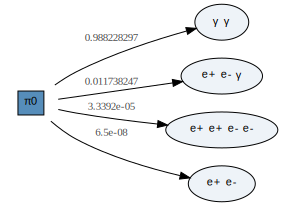

In [9]:
parser = DecFileParser('example_decays.dec')
parser.parse()
pi0_chain = parser.build_decay_chains("pi0")
DecayChainViewer(pi0_chain)

## Creating a GenMultiDecay object
A regular `phasespace.GenParticle` instance would not be able to simulate this decay, since the $\pi^0$ particle can decay in four different ways. However, a `GenMultiDecay` object can be created directly from a DecayLanguage dict:

In [10]:
pi0_decay = GenMultiDecay.from_dict(pi0_chain)

When creating a `GenMultiDecay` object, the DecayLanguage dict is "unpacked" into separate GenParticle instances, where each GenParticle instance corresponds to one way that the particle can decay.

These GenParticle instances and the probabilities of that decay mode can be accessed via `GenMultiDecay.gen_particles`. This is a list of tuples, where the first element in the tuple is the probability and the second element is the GenParticle.

In [29]:
for probability, particle in pi0_decay.gen_particles:
    print(f"There is a probability of {probability} "
          f"that pi0 decays into {', '.join(child.name for child in particle.children)}")

There is a probability of 0.988228297 that pi0 decays into gamma, gamma [0]
There is a probability of 0.011738247 that pi0 decays into e+, e-, gamma [1]
There is a probability of 3.3392e-05 that pi0 decays into e+ [0], e+ [1], e- [0], e- [1]
There is a probability of 6.5e-08 that pi0 decays into e+ [2], e- [2]


One can simulate this decay using the `.generate` method, which works the same as the `GenParticle.generate` method.

When calling the `GenMultiDecay.generate` method, it internally calls the generate method on the of the GenParticle instances in `GenMultiDecay.gen_particles`. The outputs are placed in a list, which is returned.

In [11]:
weights, events = pi0_decay.generate(n_events=10_000)
print("Number of events for each decay mode:", ", ".join(str(len(w)) for w in weights))

Number of events for each decay mode: 9881, 119


We can confirm that the counts above are close to the expected counts based on the probabilities.

## Changing mass settings
Since DecayLanguage dicts do not contain any information about the mass of a particle, the `fromdecay` submodule uses the [particle](https://github.com/scikit-hep/particle) package to find the mass of a particle based on its name.
The mass can either be a constant value or a function (besides the top particle, which is always a constant).
These settings can be modified by passing in additional parameters to `GenMultiDecay.from_dict`.
There are two optional parameters that can be passed to `GenMultiDecay.from_dict`: `tolerance` and `mass_converter`.

### Constant vs variable mass
If a particle has a width less than `tolerance`, its mass is set to a constant value.
This will be demonsttrated with the decay below:

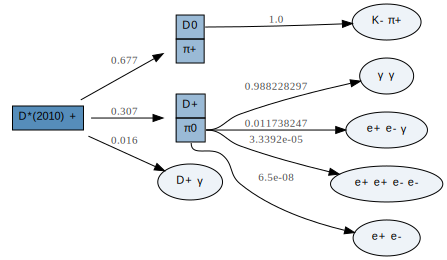

In [31]:
dsplus_chain = parser.build_decay_chains("D*+", stable_particles=["D+"])
DecayChainViewer(dsplus_chain)

In [32]:
print(f"pi0 width = {Particle.from_evtgen_name('pi0').width}\n"
      f"D0 width = {Particle.from_evtgen_name('D0').width}")

pi0 width = 7.81e-06
D0 width = 1.605e-09


$\pi^0$ has a greater width than $D^0$.
If the tolerance is set to a value between their widths, the $D^0$ particle will have a constant mass while $\pi^0$ will not.

### Configuring mass functions
Consider for example the previous $D^{*+}$ example:

![D*+ decay](Dsp_decay.svg)

By default, the mass function used for variable mass is the relativistic Breit-Wigner distribution. This can however be changed. If you want the mother particle to have a specific mass function for a specific decay, you can add a `zfit` parameter to the DecayLanguage dict, e.g., when it decays to two photons:

In [33]:
dsplus_custom_mass_func = deepcopy(dsplus_chain)
dsplus_chain_subset = dsplus_custom_mass_func["D*+"][1]["fs"][1]
# Set the mass function of pi0 to a gaussian distribution when it decays into two photons (gamma)
dsplus_chain_subset["pi0"][0]["zfit"] = "gauss"
pprint(dsplus_chain_subset)

{'pi0': [{'bf': 0.988228297,
          'fs': ['gamma', 'gamma'],
          'model': 'PHSP',
          'model_params': '',
          'zfit': 'gauss'},
         {'bf': 0.011738247,
          'fs': ['e+', 'e-', 'gamma'],
          'model': 'PI0_DALITZ',
          'model_params': ''},
         {'bf': 3.3392e-05,
          'fs': ['e+', 'e+', 'e-', 'e-'],
          'model': 'PHSP',
          'model_params': ''},
         {'bf': 6.5e-08,
          'fs': ['e+', 'e-'],
          'model': 'PHSP',
          'model_params': ''}]}


Notice the added `zfit` field to the first decay mode of the $\pi^0$ particle. This dict can then be passed to `GenMultiDecay.from_dict`, like before.

In [34]:
GenMultiDecay.from_dict(dsplus_custom_mass_func)

If you want all $\pi^0$ particles to decay with the same mass function, you do not need to specify the `zfit` parameter for each decay in the `dict`. Instead, one can pass the `particle_model_map` parameter to the constructor:

In [35]:
GenMultiDecay.from_dict(dsplus_chain, particle_model_map={'pi0': 'gauss'})    # pi0 always decays with a gaussian mass distribution.

When using `DecayChain`s, the syntax for specifying the mass function becomes cleaner:

In [12]:
dplus_decay = DecayMode(1, "K- pi+ pi+ pi0", model="PHSP")  # The model parameter will be ignored by GenMultiDecay
pi0_decay = DecayMode(1, "gamma gamma", zfit="gauss")   # Make pi0 have a gaussian mass distribution
dplus_single = DecayChain("D+", {"D+": dplus_decay, "pi0": pi0_decay})
GenMultiDecay.from_dict(dplus_single.to_dict())

#### Extra: Custom mass functions
The built-in supported mass function names are `gauss`, `bw`, and `relbw`, with `gauss` being the gaussian distribution, `bw` being the Breit-Wigner distribution, and `relbw` being the relativistic Breit-Wigner distribution.

If a non-supported value for the `zfit` parameter is specified, it will automatically use the relativistic Breit-Wigner distribution. This behavior can be changed by changing the value of `GenMultiDecay.DEFAULT_MASS_FUNC` to a different string, e.g., `"gauss"`. If an invalid value for the `zfit` parameter is used, a `KeyError` is raised.

It is also possible to add your own mass functions besides the built-in ones. You should then create a function that takes the mass and width of a particle and returns a mass function with the [format](https://phasespace.readthedocs.io/en/stable/usage.html#resonances-with-variable-mass) that is used for all phasespace mass functions. Below is an example of a custom gaussian distribution (implemented in the same way as the built-in gaussian distribution), which uses `zfit` PDFs:

In [ ]:
def custom_gauss(mass, width):
    particle_mass = tf.cast(mass, tf.float64)
    particle_width = tf.cast(width, tf.float64)

    # This is the actual mass function that will be returned
    def mass_func(min_mass, max_mass, n_events):
        min_mass = tf.cast(min_mass, tf.float64)
        max_mass = tf.cast(max_mass, tf.float64)
        # Use a zfit PDF
        pdf = zfit.pdf.Gauss(mu=particle_mass, sigma=particle_width, obs="")
        iterator = tf.stack([min_mass, max_mass], axis=-1)
        return tf.vectorized_map(
            lambda lim: pdf.sample(1, limits=(lim[0], lim[1])), iterator
        )

    return mass_func

This function can then be passed to `GenMultiDecay.from_dict` as a dict, where the key specifies the `zfit` parameter name. In the example below, it is set to `"custom_gauss"`. However, this name can be chosen arbitrarily and does not need to be the same as the function name.

In [ ]:
dsplus_chain_subset = dsplus_custom_mass_func["D*+"][1]["fs"][1]
# Set the mass function of pi0 to the custom gaussian distribution
#  when it decays into an electron-positron pair and a photon (gamma)
dsplus_chain_subset["pi0"][1]["zfit"] = "custom_gauss"
pprint(dsplus_chain_subset)

In [ ]:
GenMultiDecay.from_dict(dsplus_custom_mass_func, {"custom_gauss": custom_gauss})

## Summary
- PhaseSpace is a package for phase space simulations in Python
- The newly developed `GenMultiDecay` class makes it easy to load and simulate decays from DecayLanguage in PhaseSpace
- `GenMultiDecay` also makes it easy to customize resonances by setting the mass to be constant or variable, and which mass function to simulate